In [36]:
# Google Colab specific
%cd ~/../content
!rm -rf openet

!git clone https://github.com/aetriusgx/openet.git
%cd openet

/content
Cloning into 'openet'...
remote: Enumerating objects: 2155, done.
remote: Counting objects: 100% (573/573), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 2155 (delta 345), reused 547 (delta 327), pack-reused 1582
Receiving objects: 100% (2155/2155), 52.28 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Updating files: 100% (1704/1704), done.
/content/openet


In [37]:
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [38]:
historical = pd.read_csv('data/historical_data.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62460 entries, 0 to 62459
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         62460 non-null  datetime64[ns]
 1   actual_et    62460 non-null  float64       
 2   field_id     62460 non-null  object        
 3   crop         62460 non-null  int64         
 4   actual_eto   62460 non-null  float64       
 5   actual_etof  62460 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 2.9+ MB


In [39]:
forecasting_table = pd.read_csv('data/forecasts_table.csv', low_memory=False)
forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])

forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387960 entries, 0 to 387959
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  387960 non-null  datetime64[ns]
 1   field_id          387960 non-null  object        
 2   crop              387960 non-null  int64         
 3   time              387960 non-null  datetime64[ns]
 4   expected_et       387960 non-null  float64       
 5   expected_eto      387960 non-null  float64       
 6   expected_etof     387960 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 20.7+ MB


In [40]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt

,forecasting_date,field_id,crop,time,actual_et,actual_eto,actual_etof,expected_et,expected_eto,expected_etof
0,2024-12-30,CA_52501,75,2024-12-31,NaN,NaN,NaN,0.809,1.183,0.684
1,2024-12-30,CA_52501,75,2024-12-30,NaN,NaN,NaN,0.791,1.157,0.684
2,2024-12-30,CA_52501,75,2024-12-29,NaN,NaN,NaN,0.761,1.114,0.683
3,2024-12-30,CA_52501,75,2024-12-28,NaN,NaN,NaN,0.745,1.093,0.682
4,2024-12-30,CA_52501,75,2024-12-27,NaN,NaN,NaN,0.758,1.114,0.680
...,...,...,...,...,...,...,...,...,...,...
387955,2024-01-01,CA_89335,61,2024-12-27,NaN,NaN,NaN,0.679,1.459,0.466
387956,2024-01-01,CA_89335,61,2024-12-28,NaN,NaN,NaN,0.690,1.399,0.501
387957,2024-01-01,CA_89335,61,2024-12-29,NaN,NaN,NaN,0.677,1.305,0.519
387958,2024-01-01,CA_89335,61,2024-12-30,NaN,NaN,NaN,0.714,1.341,0.536


In [41]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

## Helpers

In [42]:
def calculate_metrics(data: pd.DataFrame, *, historical: pd.DataFrame, actual: str, expected: str, normalize: bool = False) -> pd.Series:
	mae = mean_absolute_error(data[actual], data[expected])
	forecast_mse = mean_squared_error(data[actual], data[expected])

	rmse = np.sqrt(forecast_mse)
	cor = r2_score(data[actual], data[expected])
	bias = np.mean(data[actual] - data[expected])

	# Climatology uses the mean of actual_et for that time of year using historical data.
	# Trim down historical reference to just the field, and crops provided
	field = data.head(1).squeeze()
	field_crop_table = historical[(historical['field_id'] == field['field_id']) & (historical['crop'] == field['crop'])]

	# Create a column for day of the year
	field_crop_table['doy'] = field_crop_table['time'].dt.dayofyear

	# Trim down historical reference table so only dates provided by the input DataFrame are calculated
	start_date = data['time'].min()
	end_date = data['time'].max()
	historical_period = field_crop_table[(field_crop_table['doy'] >= start_date.dayofyear) & (field_crop_table['doy'] <= end_date.dayofyear)]

	# Produce table of historical averages for current index
	climatology = historical_period.groupby([historical_period['doy']])[actual].agg(np.mean)
	climatology_mse = mean_squared_error(data[actual], climatology)

	# Negative skill scores indicate the MSE for forecast is larger than the MSE for climatology
	# Positive skill scores indicate otherwise
	skill_score = 1 - (forecast_mse / climatology_mse)

	if normalize:
		mean_variable = historical[historical['field_id'] == field['field_id']][actual].mean()
		mae = mae / mean_variable
		rmse = np.sqrt(forecast_mse / mean_variable)
		bias = bias / mean_variable

	return pd.Series({
		'mae': mae.round(2),
		'rmse': rmse.round(2),
		'corr': cor.round(2),
		'bias': bias.round(2),
		'skill_score': skill_score.round(2)
	})

In [43]:
def timeseries_plot(data, *, x, y_a, y_b=None, title='', ylabel, xlabel, figsize=(6, 4), **kwargs):
    figure, xa = plt.subplots(figsize=figsize)
    xb = xa.twinx() if y_b else None

    if y_a:
        first_line = sns.lineplot(data, x=x, y=y_a, ax=xa, errorbar=None, **kwargs)
    if y_b:
        second_line = sns.lineplot(data, x=x, y=y_b, ax=xb, linestyle='dashed', errorbar=None, legend=False, **kwargs)

    # Remove y axis label for the second line
    if xb: xb.set_ylabel('')
    # first_line is the main subplot so metadata should get changed for that one
    # Relabel y axis
    if ylabel: xa.set_ylabel(ylabel)
    # Relabel x axis
    if xlabel: xa.set_xlabel(xlabel)
    # Rotate x-time axis
    first_line.tick_params(axis='x', rotation=90)
    # Relocate legend to be outside subplot
    sns.move_legend(first_line, "upper left", bbox_to_anchor=(1.25, 1))
    # Set title if specified
    first_line.set_title(title)

    figure.show()
    return (figure, xa, xb)

In [44]:
def eval_metrics(table: pd.DataFrame, **kwargs) -> pd.DataFrame:
    metrics_table = pd.DataFrame(columns=["field_id", "crop", "variable", "mae", "rmse", "corr", "bias", "skill_score"])

    et_metrics = table.reset_index().groupby(['field_id', 'crop']).apply(calculate_metrics, historical=historical,
                                                                      actual='actual_et', expected='expected_et', **kwargs).reset_index()
    et_metrics['variable'] = "ET"
    metrics_table = pd.concat([et_metrics, metrics_table], ignore_index=True)

    eto_metrics = table.reset_index().groupby(['field_id', 'crop']).apply(calculate_metrics, historical=historical,
                                                                      actual='actual_eto', expected='expected_eto', **kwargs).reset_index()
    eto_metrics['variable'] = "ETo"
    metrics_table = pd.concat([eto_metrics, metrics_table], ignore_index=True)

    etof_metrics = table.reset_index().groupby(['field_id', 'crop']).apply(calculate_metrics, historical=historical,
                                                                      actual='actual_etof', expected='expected_etof', **kwargs).reset_index()
    etof_metrics['variable'] = "ETof"
    metrics_table = pd.concat([etof_metrics, metrics_table], ignore_index=True)

    return metrics_table

# Metrics Computation

# Forecast Metrics

In [45]:
cutoff = datetime(year=2024, month=1, day=1)
metrics = dt[(~dt['actual_et'].isna()) & (dt['forecasting_date'] >= cutoff)].groupby('forecasting_date').apply(eval_metrics)

In [46]:
metrics

field_id crop   mae  rmse  corr  bias  skill_score  \
forecasting_date                                                           
2024-01-01       0   CA_105521   47  0.12  0.15 -0.49  0.08         0.34   
                 1   CA_122175   47  0.18  0.23 -0.21  0.01         0.04   
                 2   CA_137260  176  0.10  0.14 -0.70  0.04        -0.96   
                 3   CA_144104    3  0.43  0.46 -3.23  0.09        -1.68   
                 4   CA_145664   47  0.17  0.21 -1.81  0.15        -5.72   
...                        ...  ...   ...   ...   ...   ...          ...   
2024-12-30       55  CA_326575   47  0.03  0.11  0.99 -0.02         0.99   
                 56  CA_343914   47  0.03  0.10  0.98 -0.03         0.99   
                 57  CA_344925  152  0.01  0.05  1.00 -0.01         1.00   
                 58   CA_52501   75  0.12  0.54  0.95  0.12         0.98   
                 59   CA_89335   61  0.01  0.04  1.00  0.00         1.00   

                    variable  
forecasting_date              
2024-01-01       0      ETof  
                 1      ETof  
                 2      ETof  
                 3      ETof  
                 4      ETof  
...                      ...  
2024-12-30       55       ET  
                 56       ET  
                 57       ET  
                 58       ET  
                 59       ET  

[3180 rows x 8 columns]

In [47]:
metrics_norm = dt[(~dt['actual_et'].isna()) & (dt['forecasting_date'] >= cutoff)].groupby('forecasting_date').apply(eval_metrics, normalize=True)

In [48]:
metrics_norm

field_id crop   mae  rmse  corr  bias  skill_score  \
forecasting_date                                                           
2024-01-01       0   CA_105521   47  0.23  0.20 -0.49  0.16         0.34   
                 1   CA_122175   47  0.25  0.27 -0.21  0.02         0.04   
                 2   CA_137260  176  0.15  0.16 -0.70  0.05        -0.96   
                 3   CA_144104    3  0.70  0.58 -3.23  0.14        -1.68   
                 4   CA_145664   47  0.32  0.28 -1.81  0.28        -5.72   
...                        ...  ...   ...   ...   ...   ...          ...   
2024-12-30       55  CA_326575   47  0.03  0.10  0.99 -0.01         0.99   
                 56  CA_343914   47  0.02  0.09  0.98 -0.02         0.99   
                 57  CA_344925  152  0.01  0.05  1.00 -0.01         1.00   
                 58   CA_52501   75  0.05  0.34  0.95  0.05         0.98   
                 59   CA_89335   61  0.01  0.03  1.00  0.00         1.00   

                    variable  
forecasting_date              
2024-01-01       0      ETof  
                 1      ETof  
                 2      ETof  
                 3      ETof  
                 4      ETof  
...                      ...  
2024-12-30       55       ET  
                 56       ET  
                 57       ET  
                 58       ET  
                 59       ET  

[3180 rows x 8 columns]

## Plot Comparisons

In [49]:
field_limitn = 1
date_limit = datetime(year=2024, month=7, day=19)

# field_group = list(metrics_norm.groups)[:field_limitn]
# first_fields_df = pd.concat([metrics_norm.get_group(x) for x in field_group], ignore_index=True)

plotter = metrics_norm[(metrics_norm['field_id'].isin(fields[:3])) &
                       (metrics_norm.index.get_level_values(0) < date_limit)]

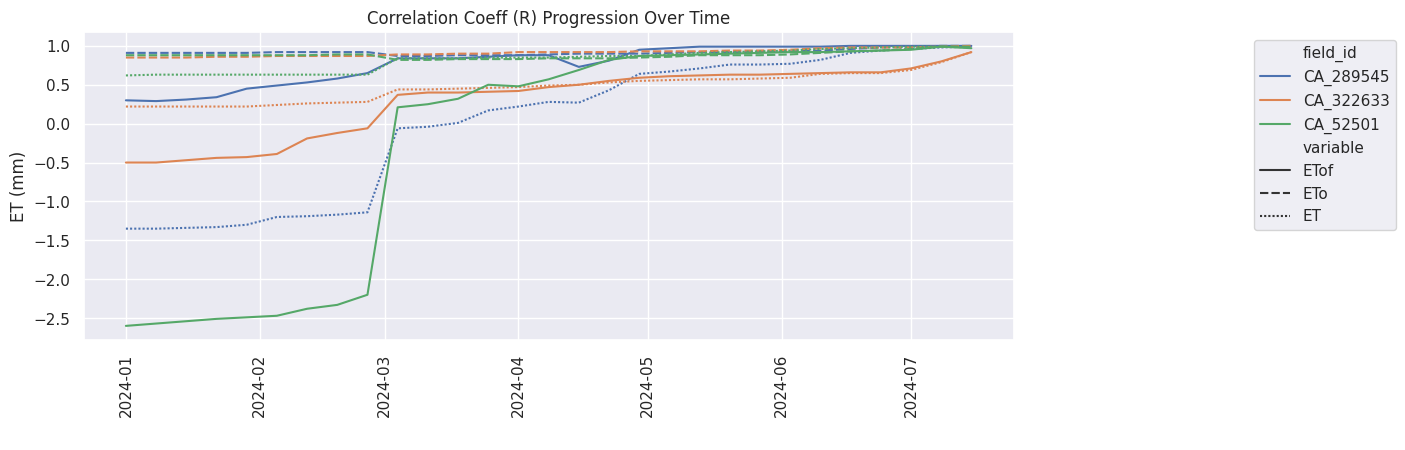

In [50]:
timeseries_plot(plotter, x='forecasting_date', y_a='corr',
                hue='field_id', title='Correlation Coeff (R) Progression Over Time', style='variable',
                xlabel=' ', ylabel='ET (mm)', figsize=(12, 4));

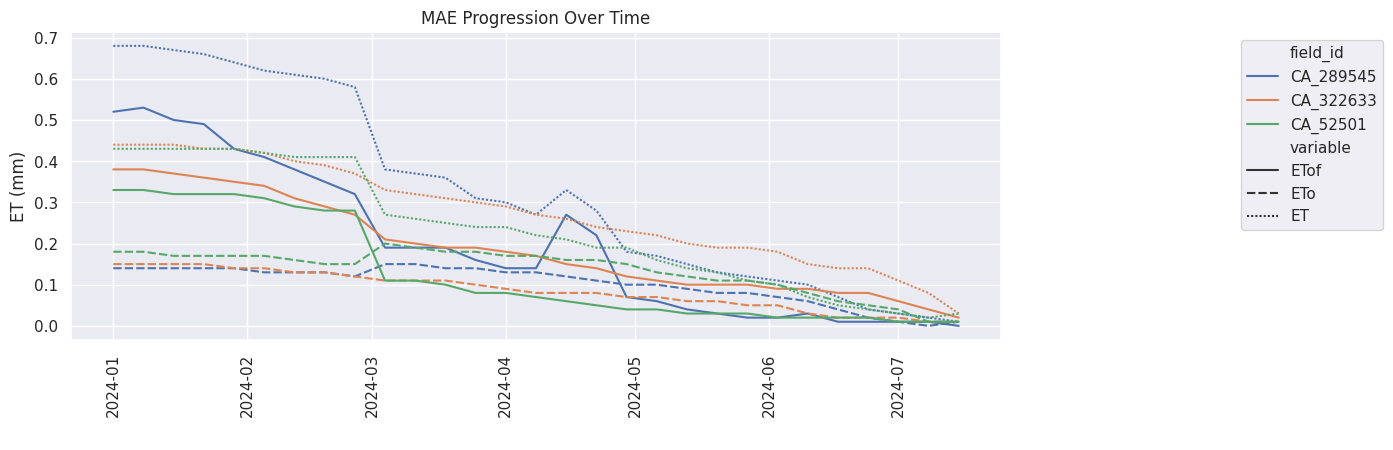

In [51]:
timeseries_plot(plotter, x='forecasting_date', y_a='mae',
                hue='field_id', title='MAE Progression Over Time', style='variable',
                xlabel=' ', ylabel='ET (mm)', figsize=(12, 4));

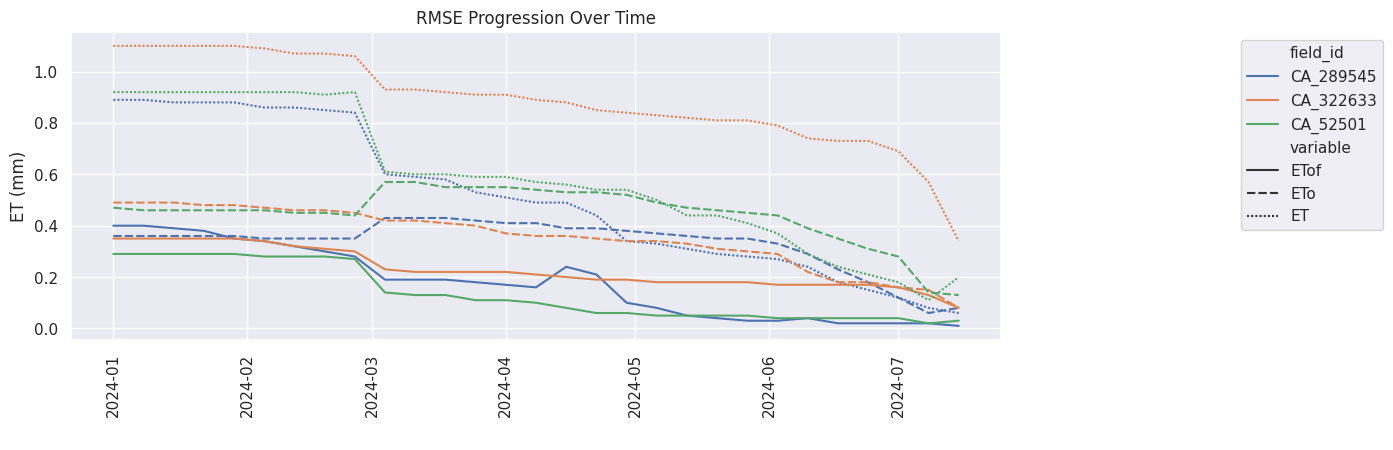

In [52]:
timeseries_plot(plotter, x='forecasting_date', y_a='rmse',
                hue='field_id', title='RMSE Progression Over Time', style='variable',
                xlabel=' ', ylabel='ET (mm)', figsize=(12, 4));

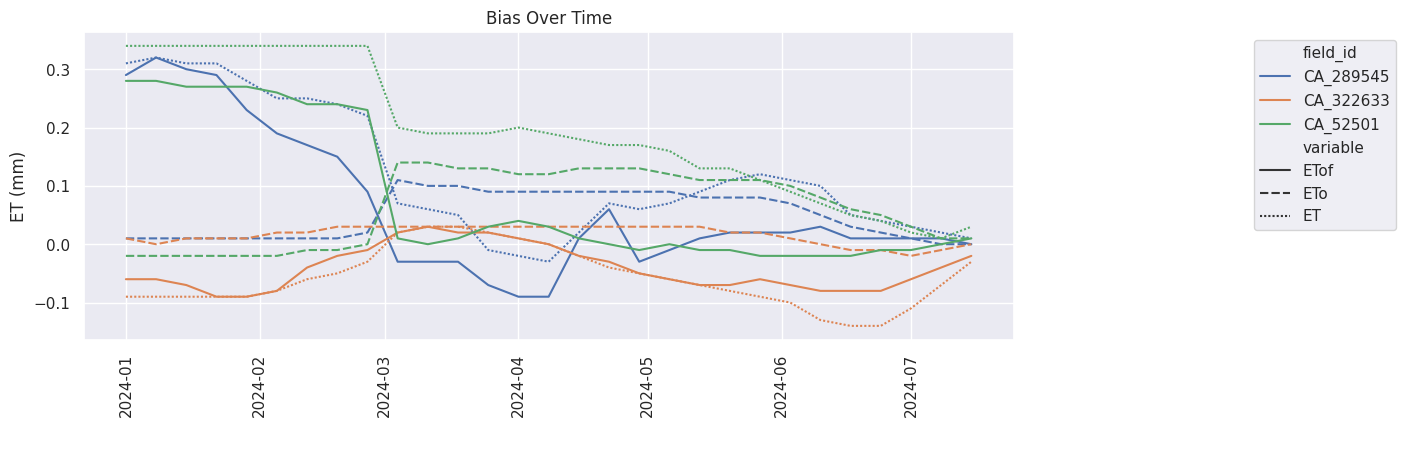

In [53]:
timeseries_plot(plotter, x='forecasting_date', y_a='bias',
                hue='field_id', title='Bias Over Time', style='variable',
                xlabel=' ', ylabel='ET (mm)', figsize=(12, 4));

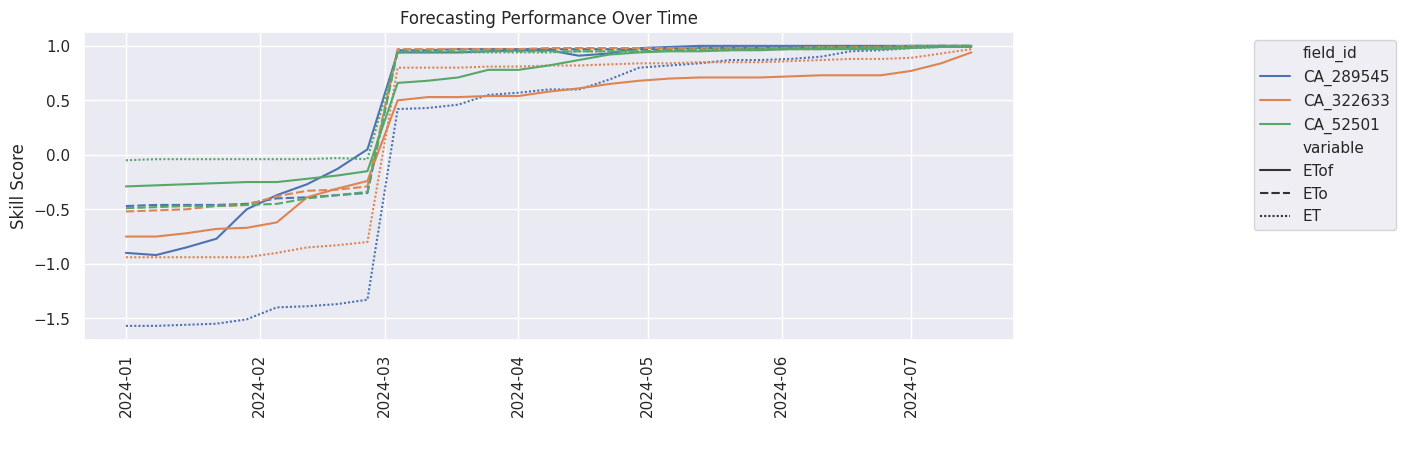

In [54]:
timeseries_plot(plotter, x='forecasting_date', y_a='skill_score',
                hue='field_id', title='Forecasting Performance Over Time', style='variable',
                xlabel=' ', ylabel='Skill Score', figsize=(12, 4));

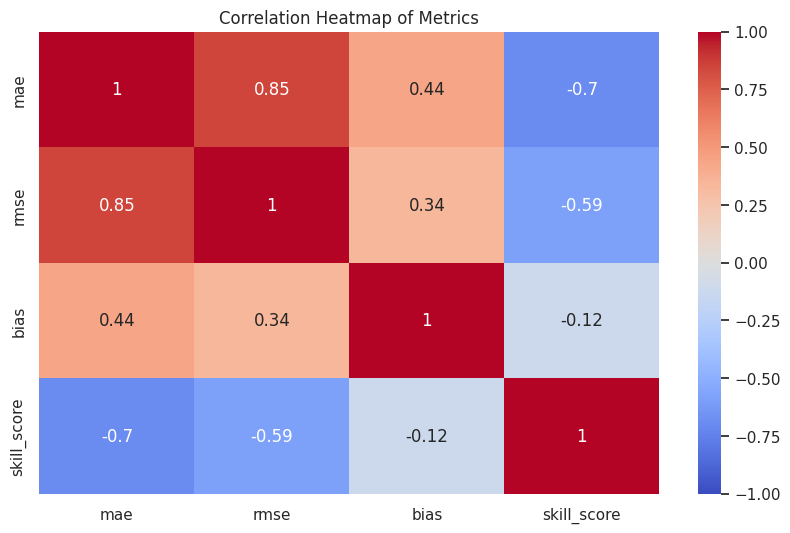

In [55]:
plt.figure(figsize=(10, 6))
metrics = ['mae', 'rmse', 'bias', 'skill_score']
corr_matrix = metrics_norm[metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Metrics')
plt.show()

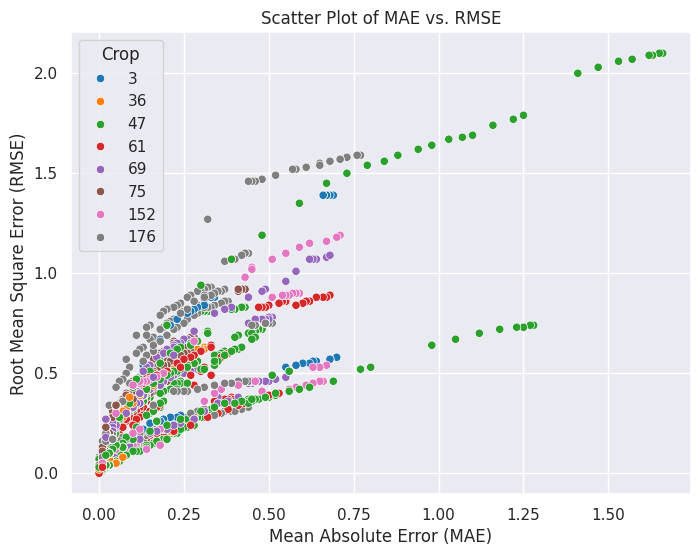

In [56]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='mae', y='rmse', data=metrics_norm, hue='crop', palette='tab10')
plt.title('Scatter Plot of MAE vs. RMSE')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.legend(title='Crop')
plt.show()

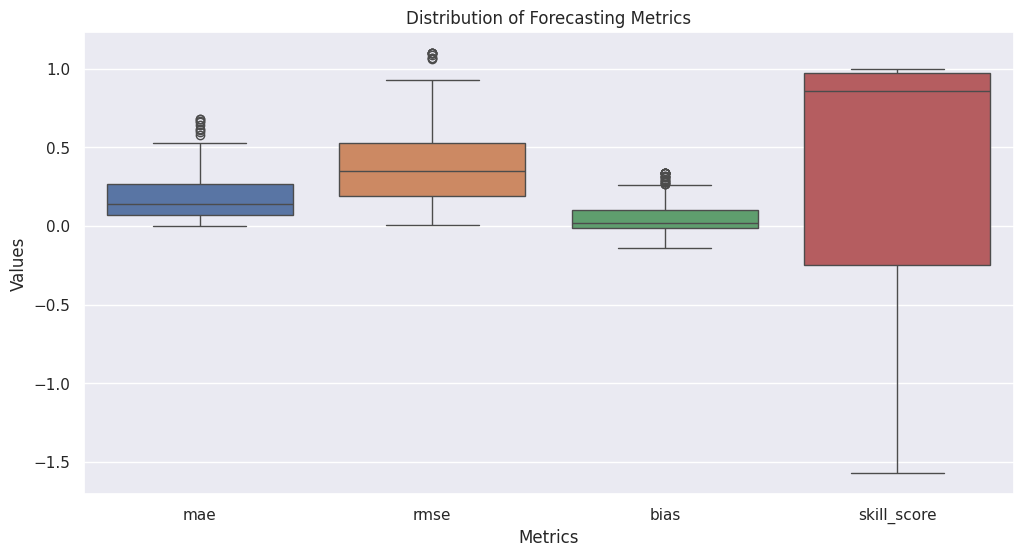

In [57]:
# Box plot for distribution of metrics
metrics = ['mae', 'rmse', 'bias', 'skill_score']
plt.figure(figsize=(12, 6))
sns.boxplot(plotter[metrics])
plt.title('Distribution of Forecasting Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()